# Predict frequency change from semantic similarity
In which we try to test whether semantic similarity can predict word success.

In [85]:
from gensim.models import Word2Vec
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

## Load data
Get embeddings first for vocabulary, then get frequencies for the relevant words.

In [4]:
embeddings = Word2Vec.load_word2vec_format('../../data/embeddings/2015_2016_wang2vec_embeddings_12000000',
                                           binary=True)

In [35]:
all_vocab = embeddings.vocab.keys()

In [37]:
test_vocab = list(set(all_vocab) & set(monthly_tf.index.tolist()))
print('%d vocab'%(len(all_vocab)))
print('%d test vocab'%(len(test_vocab)))

87425 vocab
87425 test vocab


In [43]:
# monthly_tf = pd.read_csv('../../data/frequency/2015_2016_tf_norm.tsv', sep='\t', index_col=0)
all_vocab = list(set(all_vocab) & set(monthly_tf.index.tolist()))
monthly_tf = monthly_tf.loc[all_vocab]

## Compute semantic similarities
We need average similarities with top-k neighbors...this will take a while unless we pre-compute the graph somehow. Hmm.

In [15]:
avg_semantic_similarities = {}
top_k = 5
for i,v in enumerate(all_vocab):
    top_sims = embeddings.most_similar(v, topn=top_k)
    _, top_sims = zip(*top_sims)
    avg_sim = pd.np.mean(top_sims)
    avg_semantic_similarities[v] = avg_sim
    if(i % 1000 == 0):
        print('processed %d words'%(i))
avg_semantic_similarities = pd.Series(avg_semantic_similarities)

In [16]:
avg_semantic_similarities

!             0.741539
(             0.748721
)             0.739010
,             0.804133
.             0.790791
/             0.673524
:             0.716038
;             0.710268
</s>          0.356398
?             0.757418
CAP-UNK       0.772775
CHAR-UNK      0.747194
NUM-UNK       0.725956
SUB           0.639030
USER          0.680707
[             0.716782
]             0.724182
a             0.647477
aa            0.827994
aaa           0.722281
aaah          0.812785
aaahh         0.850008
aaahhh        0.815105
aaand         0.753547
aaargh        0.857988
aac           0.849630
aadhar        0.795854
aadmi         0.950927
aah           0.787812
aahh          0.853860
                ...   
zuschauer     0.990132
zustimmen     0.990116
zuvor         0.992872
zven          0.903878
zvp           0.880640
zvt           0.877016
zvz           0.847931
zwar          0.983164
zwarte        0.799348
zwave         0.838027
zwei          0.894492
zweig         0.771829
zweihander 

In [48]:
avg_semantic_similarities = avg_semantic_similarities.loc[all_vocab]

In [49]:
'shouldn\'t' in avg_semantic_similarities.index

False

In [50]:
len(avg_semantic_similarities)

87236

Let's visualize the distribution.

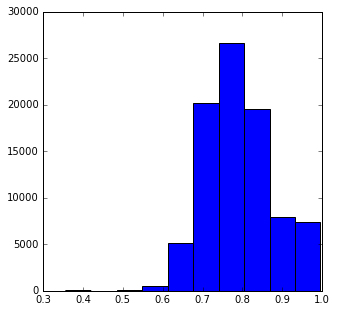

In [18]:
plt.figure(figsize=(5,5))
plt.hist(avg_semantic_similarities)
plt.show()

So most words tend to be semantically similar to their neighbors. Makes sense!

## Compute frequency deltas
What exactly are we trying to predict? Success? 

Let's define success $s_{w}$ for word $w$ as a scalar based on normalized frequency $f_{t,w}$:

$s_{w}=f_{w,12} - f_{w,0}$

In [57]:
all_dates = sorted(monthly_tf.columns)
delta = monthly_tf[all_dates[-1]] - monthly_tf[all_dates[0]]

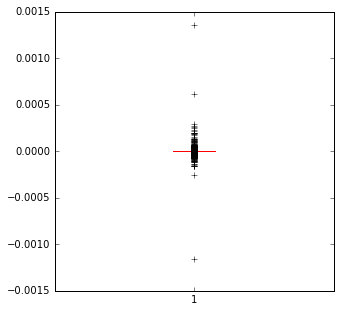

In [58]:
plt.figure(figsize=(5,5))
# nbins=20
# plt.hist(success.values, bins=nbins)
plt.boxplot(delta.values)
plt.show()

So most words don't change a lot in frequency. What if we take out the zeros?

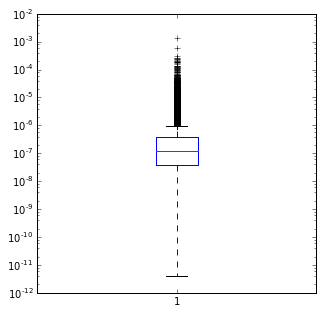

In [63]:
success = delta[delta > 0]
plt.figure(figsize=(5,5))
plt.boxplot(success.values)
plt.yscale('log')
plt.show()

In [64]:
success.sort_values(inplace=True, ascending=False)
print(success.index)

Index([u'removed', u'trump', u'hillary', u'bernie', u'please', u'clinton',
       u'bot', u'automatically', u'questions', u'post',
       ...
       u'alloys', u'blanco', u'bombcast', u'prattle', u'elezen', u'undiluted',
       u'cristian', u'philippe', u'glueing', u'gazpacho'],
      dtype='object', length=40824)


Again, only small deltas but they seem interesting!

## Predict
Start with just successes to keep things easy.

In [88]:
y = pd.np.log10(success.values)
x = [avg_semantic_similarities[w] for w in success.index]
data = pd.DataFrame({'freq_delta' : y, 'semantic_sim' : x})

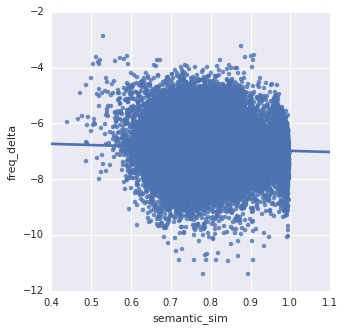

In [89]:
# visualize first
plt.figure(figsize=(5,5))
sns.regplot('semantic_sim', 'freq_delta', data=data)
plt.show()

In [90]:
slope, intercept, rvalue, pvalue, stderr = linregress(x, y=y)
print('R2=%.3E (p=%.3E)'%(rvalue, pvalue))

R2=-4.675E-02 (p=3.340E-21)


The fit sucks! It's a very weak negative fit between semantic similarity and change in frequency: words with more similar neighbors tend to have a smaller frequency increase.

What about using all nonzero delta values?

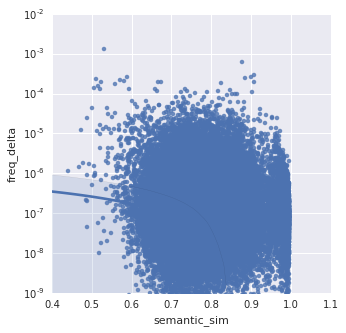

R2=-9.575E-03 (p=4.682E-03)


In [87]:
y = delta
x = [avg_semantic_similarities[w] for w in delta.index]
data = pd.DataFrame({'freq_delta' : y, 'semantic_sim' : x})
plt.figure(figsize=(5,5))
sns.regplot('semantic_sim', 'freq_delta', data=data)
plt.yscale('log')
plt.show()
slope, intercept, rvalue, pvalue, stderr = linregress(x, y=y)
print('R2=%.3E (p=%.3E)'%(rvalue, pvalue))

Fit is even worse. So we can be reasonably sure that semantic similarity to nearest neighbors doesn't accurately predict frequency change.

What if we define success as $Spearman(w)>0.5$? That way we only get words with consistent growth.

In [95]:
correls = pd.read_csv('../../data/frequency/2015_2016_norm_tf_correls.tsv', 
                      sep='\t', index_col=0)
correls.sort_values(['correl', 'pvalue'], ascending=False, inplace=True)
correls.head(n=20)

,correl,pvalue
discord,1.000000,0.000000e+00
rn,1.000000,0.000000e+00
feelsbadman,1.000000,0.000000e+00
kandidaten,1.000000,0.000000e+00
tbh,0.993007,1.301673e-10
cucked,0.993007,1.301673e-10
boku,0.993007,1.301673e-10
friendo,0.993007,1.301673e-10
berners,0.993007,1.301673e-10
doggo,0.993007,1.301673e-10


In [105]:
min_thresh = 0.5
p_val = 0.05
success = correls[(correls['correl'] >= min_thresh) & (correls['pvalue'] < p_val)]
success_vocab = list(set(all_vocab) & set(success.index))
success = success.loc[success_vocab]

In [107]:
success.loc['berner']

correl    9.930070e-01
pvalue    1.301673e-10
Name: berner, dtype: float64

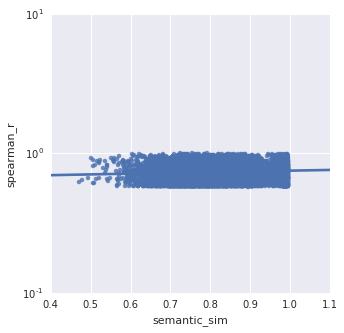

R2=8.805E-02 (p=1.278E-19)


In [108]:
y = success['correl']
x = [avg_semantic_similarities[w] for w in success.index]
data = pd.DataFrame({'spearman_r' : y, 'semantic_sim' : x})
plt.figure(figsize=(5,5))
sns.regplot('semantic_sim', 'spearman_r', data=data)
plt.yscale('log')
plt.show()
slope, intercept, rvalue, pvalue, stderr = linregress(x, y=y)
print('R2=%.3E (p=%.3E)'%(rvalue, pvalue))

Slightly stronger correlation here, so semantic similarity can be tied more strongly to consistent growth (measured with $\rho$). Maybe log-success will be better.

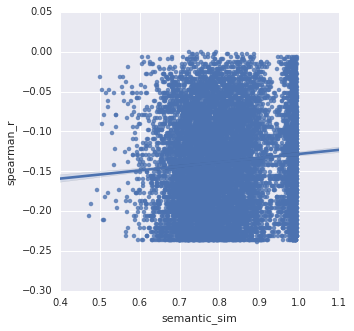

R2=8.657E-02 (p=5.108E-19)


In [109]:
y = pd.np.log10(success['correl'])
x = [avg_semantic_similarities[w] for w in success.index]
data = pd.DataFrame({'log(spearman_r)' : y, 'semantic_sim' : x})
plt.figure(figsize=(5,5))
sns.regplot('semantic_sim', 'log(spearman_r)', data=data)
# plt.yscale('log')
plt.show()
slope, intercept, rvalue, pvalue, stderr = linregress(x, y=y)
print('R2=%.3E (p=%.3E)'%(rvalue, pvalue))

Slightly worse correlation, but we see here a big gap between 0.9 and 1.0 in $semantic_sim$ values. I guess nearest neighbors tend to be all very close to 1.0 or have a lot of variance.

## Nearest-neighbor semantic similarity
TODO: Same tests as above but with $k=1$.

## Semantic similarity to most popular term
Instead of semantic similarity to neighbors, why not measure semantic similarity to the most popular nearest neighbor? Mimicking prototype theory.

What counts as "popularity"? Frequency at beginning of time, or over all time?

In [110]:
mean_monthly_tf = monthly_tf.mean(axis=1)
mean_monthly_tf.head()

fawn             1.045755e-06
fawk             2.193183e-07
redistributes    1.626512e-07
deferment        4.443028e-07
massdrop         2.230416e-06
dtype: float64

In [121]:
prototype_semantic_similarities = {}
for i, v in enumerate(all_vocab):
    # find most popular nearest neighbor
    top_sims = dict(embeddings.most_similar(v, topn=top_k))
    neighbors, _ = zip(*top_sims.items())
#     print('word %s got neighbors %s'%
#           (v, str(neighbors)))
    # popularity = mean norm popularity
    sorted_pops = mean_monthly_tf.loc[list(neighbors)].sort_values(ascending=False, 
                                                                   inplace=False)
#     print('neighbor popularity %s'%(sorted_pops))
    prototype = sorted_pops.index[0]
#     print('prototype %s has similarity %.3E (out of neighbors %s)'%
#          (prototype, top_sims[prototype], top_sims))
    prototype_sim = top_sims[prototype]
    prototype_semantic_similarities[v] = prototype_sim
    if(i % 1000 == 0):
        print('processed %d words'%(i))

processed 0 words
processed 1000 words
processed 2000 words
processed 3000 words
processed 4000 words
processed 5000 words
processed 6000 words
processed 7000 words
processed 8000 words
processed 9000 words
processed 10000 words
processed 11000 words
processed 12000 words
processed 13000 words
processed 14000 words
processed 15000 words
processed 16000 words
processed 17000 words
processed 18000 words
processed 19000 words
processed 20000 words
processed 21000 words
processed 22000 words
processed 23000 words
processed 24000 words
processed 25000 words
processed 26000 words
processed 27000 words
processed 28000 words
processed 29000 words
processed 30000 words
processed 31000 words
processed 32000 words
processed 33000 words
processed 34000 words
processed 35000 words
processed 36000 words
processed 37000 words
processed 38000 words
processed 39000 words
processed 40000 words
processed 41000 words
processed 42000 words
processed 43000 words
processed 44000 words
processed 45000 words
p

KeyError: 'None of [[u\'his\', u\'whom\', u"who\'s", u\'who\', u\'their\']] are in the [index]'

Same tests as before, defining $success(w) = Spearman(w) > 0.5$.

In [ ]:
min_thresh = 0.5
p_val = 0.05
success = correls[(correls['correl'] >= min_thresh) & (correls['pvalue'] < p_val)]
success_vocab = list(set(all_vocab) & set(success.index))
success = success.loc[success_vocab]
y = success['correl']
x = [avg_semantic_similarities[w] for w in success.index]
data = pd.DataFrame({'spearman_r' : y, 'prototype_sim' : x})
plt.figure(figsize=(5,5))
sns.regplot('prototype_sim', 'spearman_r', data=data)
plt.yscale('log')
plt.show()
slope, intercept, rvalue, pvalue, stderr = linregress(x, y=y)
print('R2=%.3E (p=%.3E)'%(rvalue, pvalue))